In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler

import pyswarms as ps

from tensorflow import keras
from keras import layers, models
from keras import losses

In [2]:
df = pdr.get_data_yahoo('GOOG', start=None, end=None)

[*********************100%%**********************]  1 of 1 completed


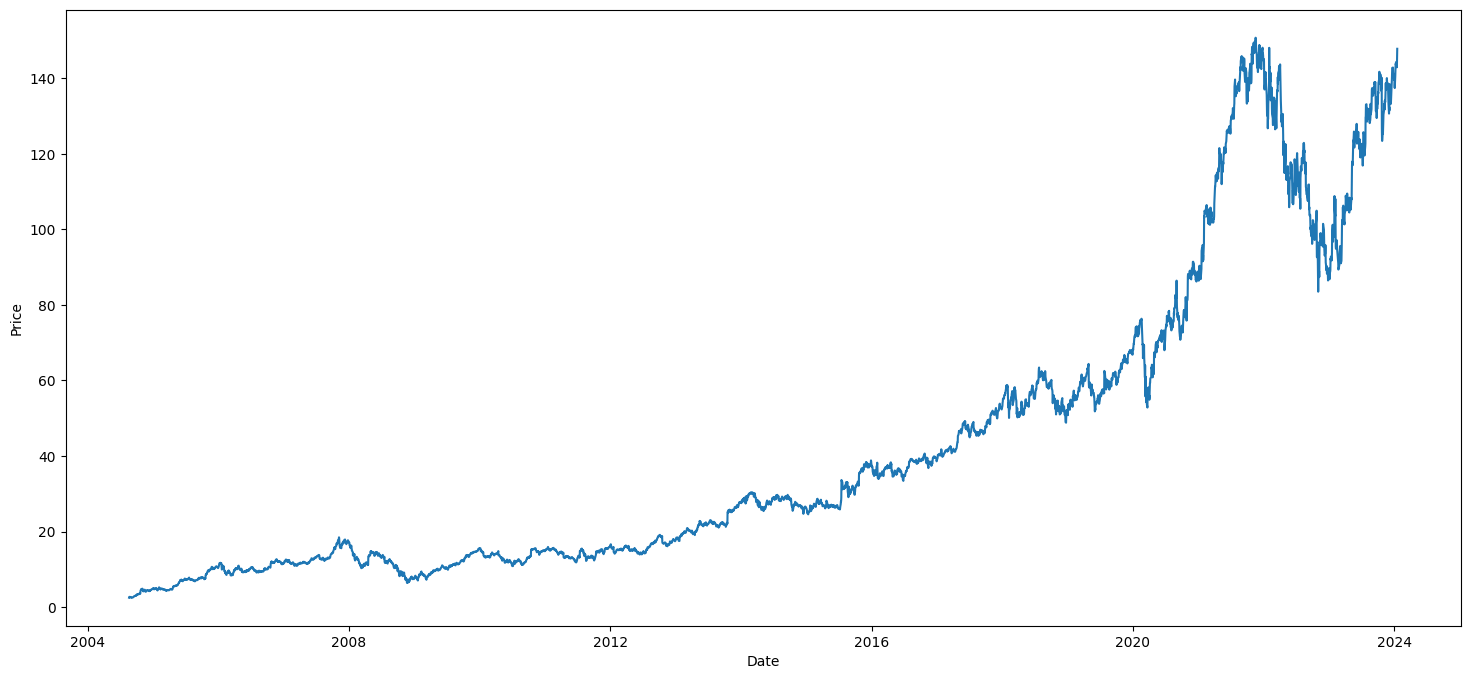

In [3]:
plt.figure(figsize=(18,8))
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
data = df.filter(['Close']) # should return a 2D array for the closing prices. Return type is a DataFrame

training_split_length = int(np.ceil(len(data)*0.95))

dataset = data.values # Return type of .values is a numpy.ndarray of dim 2

scalar = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scalar.fit_transform(dataset)

scaled_dataset.shape

(4888, 1)

In [12]:
train_data = scaled_dataset[:int(training_split_length),:]

x_train = []
y_train = []

days_in_ahead = 5

for i in range(60,len(train_data)-days_in_ahead):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i+days_in_ahead])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [21]:
def split_data(prev_days, scaled_dataset, training_split_length, **kwargs):
    train_data = scaled_dataset[:int(training_split_length),:]
    dia = kwargs['dia']
    x_train = []
    y_train = []
    for i in range(prev_days, len(train_data)-dia):
        x_train.append(train_data[i-prev_days:i,0])
        y_train.append(train_data[i+dia-1])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train

def create_model(layers, nodes, input_shape = (x_train.shape[1], 1)):
    model = keras.models.Sequential()
    for i in range(layers):
        return_sequences = i < layers - 1
        model.add(keras.layers.LSTM(nodes, return_sequences=return_sequences, input_shape=input_shape))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def evaluate_model(hyperparameters):
    layers, nodes, batch_size, epochs, prev_days = int(hyperparameters[0]), int(hyperparameters[1]), int(hyperparameters[2]), int(hyperparameters[3]), int(hyperparameters[4])
    x_train, y_train = split_data(prev_days, scaled_dataset, training_split_length, dia=4) # Corresponds to 5 days
    model = create_model(layers, nodes)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    val_loss = np.min(history.history['mean_squared_error'])
    return val_loss

def objective_function(hyperparameters):
    print("Hyperparameters Shape: {}".format(hyperparameters.shape[0]))
    n_particles = hyperparameters.shape[0]
    print(hyperparameters)
    j = [evaluate_model(hyperparameters[i]) for i in range(n_particles)]
    return np.array(j)

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Define bounds - (min, max) for each hyperparameter
# [Layers, Nodes, Batch Size, Epochs]
lower_bounds = [1, 20, 32, 10, 10]  #Lower bounds for each dimension
upper_bounds = [3, 64, 64, 20, 100]  # Upper bounds for each dimension
bounds = (lower_bounds, upper_bounds)

#Initialize swarm
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=5, options=options, bounds=bounds)

#Perform optimization
cost, pos = optimizer.optimize(objective_function, iters=2)

# Best hyperparameters
print("Best hyperparameters: Layers={}, Nodes={}, Batch Size={}, Epochs={}".format(int(pos[0]), int(pos[1]), int(pos[2]), int(pos[3])))

2024-01-19 18:35:16,076 - pyswarms.single.global_best - INFO - Optimize for 2 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/2

Hyperparameters Shape: 10
[[ 1.24828309 51.01257822 61.8048683  17.531525   86.72675945]
 [ 1.28318007 43.80309724 47.56613622 15.18473255 82.24349014]
 [ 1.20866368 51.13263939 38.68199278 14.57071064 96.01281629]
 [ 1.32635852 22.49024205 54.84076422 15.14896549 89.8965827 ]
 [ 2.31604499 20.10290544 52.06983535 13.33907329 41.58636127]
 [ 2.91814042 52.84024863 54.30857879 10.39192474 95.84691056]
 [ 2.88927769 46.81244874 57.01505086 17.92589236 45.81166206]
 [ 1.72550054 48.97282026 34.27421312 18.6738328  81.22561667]
 [ 1.21257124 59.21815453 58.64054633 14.4814918  19.52765606]
 [ 1.36849912 22.32123857 60.29157032 13.38486038 50.26359144]]


ValueError: int() base must be >= 2 and <= 36, or 0

In [ ]:
model = create_model(int(pos[0]), int(pos[1]), (x_train.shape[1], 1))
# model = create_model(1, 32, (x_train.shape[1], 1))

history = model.fit(x=x_train,y=y_train, batch_size=int(pos[2]), epochs=int(pos[3]))

Epoch 1/18
133/133 [==============================] - 2s 3ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - mean_absolute_error: 0.0989
Epoch 2/18
133/133 [==============================] - 0s 3ms/step - loss: 6.8579e-04 - mean_squared_error: 6.8579e-04 - mean_absolute_error: 0.0175
Epoch 3/18
133/133 [==============================] - 0s 3ms/step - loss: 4.6388e-04 - mean_squared_error: 4.6388e-04 - mean_absolute_error: 0.0126
Epoch 4/18
133/133 [==============================] - 0s 3ms/step - loss: 3.8466e-04 - mean_squared_error: 3.8466e-04 - mean_absolute_error: 0.0101
Epoch 5/18
133/133 [==============================] - 0s 3ms/step - loss: 3.6532e-04 - mean_squared_error: 3.6532e-04 - mean_absolute_error: 0.0091
Epoch 6/18
133/133 [==============================] - 0s 3ms/step - loss: 3.6117e-04 - mean_squared_error: 3.6117e-04 - mean_absolute_error: 0.0089
Epoch 7/18
133/133 [==============================] - 0s 3ms/step - loss: 3.6151e-04 - mean_squared_error: 3.6151e-04 - 

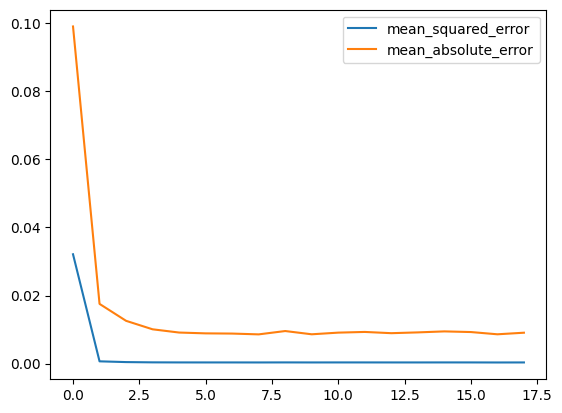

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['mean_squared_error', 'mean_absolute_error'])
plt.show()

In [ ]:
test_data = scaled_dataset[training_split_length-60:,:]
x_test = []
y_test = dataset[training_split_length:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scalar.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test)**2)))

rmse

3/3 [==============================] - 0s 2ms/step


3.670638402923149

C:\Users\Brandon\AppData\Local\Temp\ipykernel_21688\227710221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions[:,:]


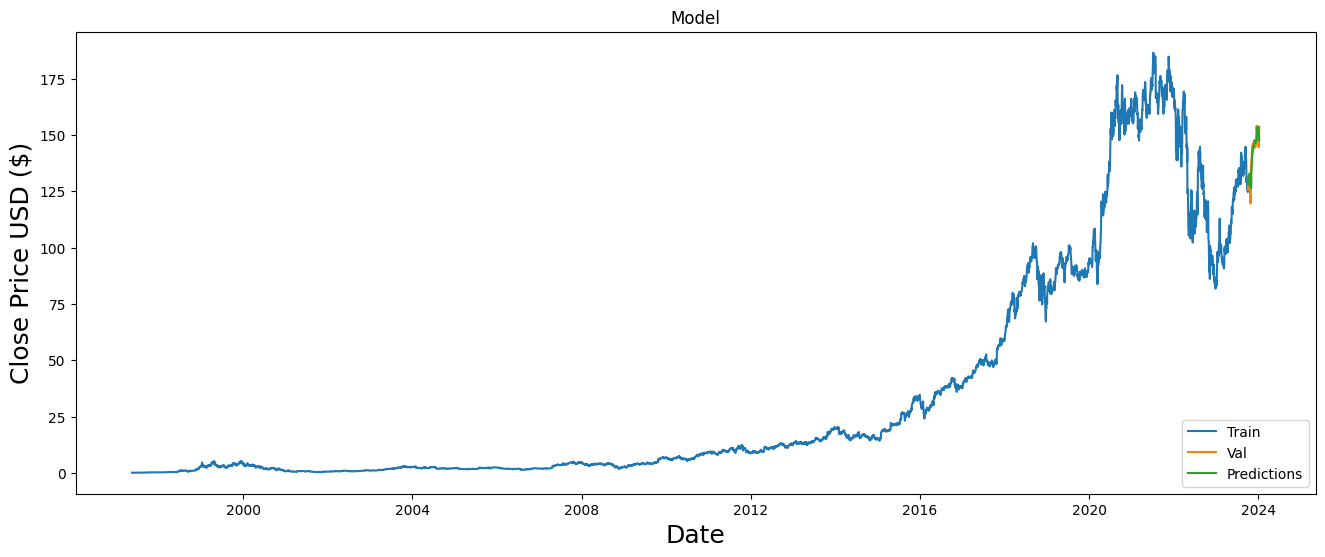

In [ ]:
train = data[:training_split_length]
valid = data[training_split_length:]
valid['Predictions'] = predictions[:,:]
#Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
close_price = valid['Close'].values
prediction_price = valid['Predictions'].values
accuracy = lambda close, pred: min(close, pred)/max(close, pred) * 100
accuracy_lst = np.array([accuracy(close, pred) for close,pred in zip(close_price, prediction_price)])
accuracy = np.average(accuracy_lst)
accuracy

98.10238176066407

In [ ]:
late_test = scaled_dataset[-60:,:]
late_test = np.reshape(late_test, (1, 60, 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 18ms/step


array([[148.03601]], dtype=float32)

In [ ]:
late_test = scaled_dataset[-63:-3,:]
late_test = np.reshape(late_test, (1, 60, 1))
late_test.shape

late_prediction = model.predict(late_test)
late_prediction = scalar.inverse_transform(late_prediction)
late_prediction

1/1 [==============================] - 0s 22ms/step


array([[149.40627]], dtype=float32)

In [ ]:
data.iloc[-63:-3,:]

,Close
Date,
2023-12-29,151.940002
2024-01-02,149.929993
2024-01-03,148.470001
2024-01-04,144.570007
2024-01-05,145.240005


In [ ]:
valid

,Close,Predictions
Date,,
2023-10-05,125.959999,128.367264
2023-10-06,127.959999,128.563629
2023-10-09,128.259995,128.504883
2023-10-10,129.479996,127.838013
2023-10-11,131.830002,128.783081
...,...,...
2024-01-04,144.570007,152.308731
2024-01-05,145.240005,151.080307
2024-01-08,149.100006,149.406265
